iter:100 training loss: 0.2064914107322693, val loss: 0.2778816223144531
iter:200 training loss: 0.15473544597625732, val loss: 0.17780902981758118
iter:300 training loss: 0.1059335470199585, val loss: 0.13571719825267792
iter:400 training loss: 0.11490935832262039, val loss: 0.10946402698755264
iter:500 training loss: 0.10751595348119736, val loss: 0.11599177122116089
iter:600 training loss: 0.07358601689338684, val loss: 0.10503210127353668
iter:700 training loss: 0.09621362388134003, val loss: 0.07535946369171143
iter:800 training loss: 0.09066867083311081, val loss: 0.05696885287761688
iter:900 training loss: 0.07745902240276337, val loss: 0.07244747132062912
iter:1000 training loss: 0.06314849108457565, val loss: 0.0617133229970932
iter:1100 training loss: 0.037394389510154724, val loss: 0.05907035991549492
iter:1200 training loss: 0.07767727226018906, val loss: 0.055504027754068375
iter:1300 training loss: 0.04933636263012886, val loss: 0.0500185452401638
iter:1400 training loss:

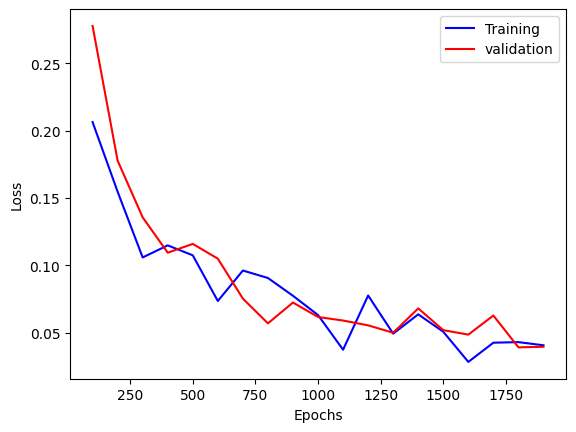

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from utils import *

def sample_data(split = 'train'):
    if split == 'train':
        data =  training_dataset
    else:
        data = validation_dataset
    
    ix = torch.randperm(data.shape[0])[:batch_size]
    
    return data[ix]

learning_rate = 0.01
max_iters = 2000
batch_size = 32

iters = []
loss_value = []
val_loss_value = []

dataset = torch.load("data/hidden.pt")
dataset_size = dataset.shape[0]
training_dataset = dataset[:int(dataset_size*0.5)]
validation_dataset = dataset[int(dataset_size*0.5):]
model = SAE(SAE_Config())

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = SAE(SAE_Config())
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X= sample_data()
        _, loss,_ = model(X)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V = sample_data(split= 'val')
                _, val_loss, _ = model(X_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()



        






In [34]:


_, _, hidden = model(training_dataset)
print("Non zero entries",(hidden>0).sum(-1).float().mean())


Non zero entries tensor(2.3831)


In [35]:
print((hidden>0).sum(0))
print(hidden.shape)
print(hidden.max())

tensor([    0,     0,     0, 14715,     0, 40632,     0,     1,     1, 41223,
            0,     0,     0,     0,  3509,     0,     0,     0,     0,     0,
        46998, 50510,     0,     1,     0,     0,     7, 45572, 43143,     0,
            1,     0,     0,     0, 43511,     0,     0,     0,     0,     0,
            0,     0,     0, 14619,     0,     0, 46012,     0,     0,     0])
torch.Size([163840, 50])
tensor(0.4053, grad_fn=<MaxBackward1>)


In [12]:
sp = SuperpositionModel(SuperPositionConfig())
PATH = "models/superpositon.pt"
sp.load_state_dict(torch.load(PATH))
print(sp.eval())
original_data  = torch.load("data/original.pt")

SuperpositionModel(
  (encoder): Linear(in_features=20, out_features=5, bias=False)
  (decoder): Linear(in_features=5, out_features=20, bias=True)
  (relu): ReLU()
)


In [13]:
logits, loss, hidden = sp(original_data, original_data)
_,_, latents = model(hidden)
print(hidden.shape, loss, latents.shape, original_data.shape)

torch.Size([327680, 5]) tensor(0.0006, grad_fn=<MeanBackward0>) torch.Size([327680, 50]) torch.Size([327680, 20])


In [14]:
freqs = (latents>0).sum(0)
print(freqs)

tensor([     0,      0,      0,      1,      0,      4,      0,  89074,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
         29245,      0,      0,      0,      0,      0,      0,  96646,      1,
             0,      0,  65001,      1,  91816,  29959,      0,      0,      5,
         81069,      0,      0, 111060,      2,      0,      0,      0,      0,
             0,      0,  83654,      0,  85844])


In [15]:
for i in range(50):
   indices = latents[:, i] > 0.01
   x =  original_data[indices]
   _, loss, _ = sp(x, x)
   if freqs[i] and loss.item():
      print(i, loss.item(), freqs[i].item())

   

3 0.006320849992334843 1
5 0.0015114188427105546 4
7 0.0009965597419068217 89074
18 0.0009064190671779215 29245
25 0.0009952174732461572 96646
26 nan 1
29 0.0013815474230796099 65001
30 nan 1
31 0.000996768823824823 91816
32 0.0009675128385424614 29959
35 0.00379703426733613 5
36 0.0011880500242114067 81069
39 0.0010040253400802612 111060
40 0.0011936698574572802 2
47 0.0010775703703984618 83654
49 0.0008814900065772235 85844


In [17]:
for i in range(20):
   indices = original_data[:, i] > 0
   x =  original_data[indices]
   _, loss, _ = sp(x, x)
   if loss.item():
      print(i, loss.item(), indices.shape[0])


0 0.0015597204910591245 327680
1 0.001937464578077197 327680
2 0.0016054970910772681 327680
3 0.001433726865798235 327680
4 0.0015894395764917135 327680
5 0.001118100481107831 327680
6 0.0012401770800352097 327680
7 0.0013664085417985916 327680
8 0.0014025279087945819 327680
9 0.0011954806977882981 327680
10 0.001154979458078742 327680
11 0.0008709246176294982 327680
12 0.0011703635100275278 327680
13 0.0007613555644638836 327680
14 0.0007261190912686288 327680
15 0.0007009381079114974 327680
16 0.0006641401560045779 327680
17 0.0006633097655139863 327680
18 0.0006466695922426879 327680
19 0.0006163509096950293 327680


In [13]:



get_reconstructed_loss(sp, model, original_data)

reconstructed loss 0.01789555512368679, original 0.013135502114892006. Percentage 99.92772674560547%
